В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [39]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [40]:
def plot_data(A, b, test = False):
    positive_indices = np.where(b == 1)[0]
    negative_indices = np.where(b == 0)[0]
    
    plt.scatter(A[positive_indices, 0], A[positive_indices, 1], marker='*', c= 'blue' if test else 'red')
    plt.scatter(A[negative_indices, 0], A[negative_indices, 1], marker='+', c= 'green' if test else 'black')

In [41]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    # hidden_layer_sizes=(100, 50,)
    def __init__(self, hidden_layer_sizes, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x):
        self.parameters = {}
        n = len(n_x)
        
        for i in range(1, len(n_x)):
            if (i == n):
                continue
            W = np.random.randn(n_x[i], n_x[i - 1]) * 0.01
            b = np.zeros((n_x[i], 1))
            self.parameters.update({f"W{i}": W, f"b{i}": b})

        W = np.random.randn(1, n_x[n-1]) * 0.01
        b = 0
        
        self.parameters.update({f"W{n}":W, f"b{n}":b})
                    
    def __forward_propagation(self, X):
        num_layers = len(self.hidden_layer_sizes)
        cache = self.parameters.copy()
        
        A = X
        for i in range(1, num_layers + 2):
            W = self.parameters[f"W{i}"]
            b = self.parameters[f"b{i}"]
            Z = np.dot(W, A) + b
            A = self.__sigmoid(Z)
            cache.update({f"Z{i}": Z})
            cache.update({f"A{i}": A})
        return A, cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        num_layers = len(self.hidden_layer_sizes)
        
        grads = {}
        
        for i in range(num_layers+1, 0, -1):
            W = cache[f"W{i}"]
            b = cache[f"b{i}"]
            Z = cache[f"Z{i}"]

            if i == num_layers + 1:
                A = cache[f"A{i}"]
                A_next = cache[f"A{i - 1}"]
                
                dZ = A - Y
                dW = 1. / m * np.dot(dZ, A_next.T)
                db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
            elif (i == 1):
                W_prev = cache[f"W{i + 1}"]
                A = cache[f"A{i}"]
                dA = np.dot(W_prev.T, dZ)

                dZ = np.multiply(dA, np.multiply(A, 1 - A))
                dW = 1. / m * np.dot(dZ, X.T)
                db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
            else:
                W_prev = cache[f"W{i + 1}"]
                A = cache[f"A{i}"]
                A_next = cache[f"A{i - 1}"]

                dA = np.dot(W_prev.T, dZ)
                dZ = np.multiply(dA, np.multiply(A, 1 - A))
                dW = 1. / m * np.dot(dZ, A_next.T)
                db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
            grads.update({f"dZ{i}":dZ, f"dW{i}":dW, f"db{i}":db})
        return grads
    
    def __update_parameters(self, grads):
        num_layers = len(self.hidden_layer_sizes)
        
        for i in range(1, num_layers + 2):
            W = self.parameters[f"W{i}"]
            b = self.parameters[f"b{i}"]
            
            dW = grads[f"dW{i}"]
            db = grads[f"db{i}"]
            
            self.parameters[f"W{i}"] = W - self.learning_rate * dW
            self.parameters[f"b{i}"] = b - self.learning_rate * db
            
    def fit(self, X_vert, Y_vert, epsilon=1e-08, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        m = X.shape[1]
        n_x = (X.shape[0],) + self.hidden_layer_sizes
        
        self.__initialize_parameters(n_x)
        
        
        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))
            costs.append(cost)
            
            # break condition
            if i > 1 and abs(costs[-2] - costs[-1]) < epsilon:
                break
                
        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()

            
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        print(probs)
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)

Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [42]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [43]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


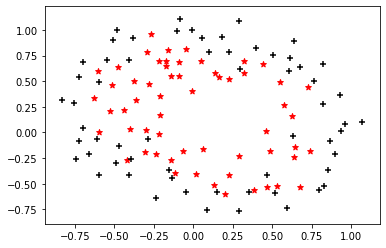

In [44]:
plot_data(X, Y)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(94, 2), y=(94,)
Test set: X=(24, 2), y=(24,)


0-th iteration: 0.6935436489119651
1000-th iteration: 0.6699978180092107
2000-th iteration: 0.4528677581253461
3000-th iteration: 0.36146876203110867


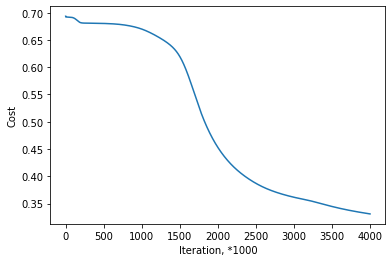

In [46]:
cls = NeuralNet((20, ), normalize = True, learning_rate = 0.5, num_iter = 4000)
cls.fit(X_train, y_train.values.reshape((X_train.shape[0], 1)), epsilon=1e-8)

In [47]:
print(cls.parameters)

{'W1': array([[-0.91945293, -0.52282135],
       [-1.0027716 , -0.8298758 ],
       [-0.45215898,  2.44115994],
       [ 0.24059692, -0.37314354],
       [ 0.25572725, -0.46232119],
       [ 0.30841469, -0.53793979],
       [-3.35532366, -0.82191539],
       [-0.87066062,  0.95012035],
       [ 0.41618475, -0.82536903],
       [ 0.34765062, -0.63275782],
       [-1.11768363, -0.65907411],
       [ 0.22554436, -0.17390032],
       [-1.23751123,  0.99155918],
       [ 0.37796153,  2.16010693],
       [ 0.38409441, -1.0126261 ],
       [-2.23273568, -1.92497708],
       [-0.93977091, -0.54375961],
       [ 0.26769761, -0.46916139],
       [ 0.20019238, -0.25909163],
       [ 0.4775868 , -1.09758206]]), 'b1': array([[-1.93066433],
       [-2.79399426],
       [-2.87493689],
       [-0.05504637],
       [-0.17628886],
       [-0.14038726],
       [-2.51049512],
       [-3.58230642],
       [-0.49814013],
       [-0.33179455],
       [-2.67683989],
       [ 0.0855653 ],
       [ 3.10976611],

In [48]:
Y_prob = cls.predict_proba(X_test)
Y_prob

[[0.06183286 0.19822767 0.31686864 0.98401256 0.94964441 0.17023949
  0.06386704 0.26843984 0.82053186 0.54507405 0.68647447 0.02801745
  0.01681802 0.3814979  0.53121469 0.88258231 0.02953173 0.20238164
  0.98716065 0.06215987 0.1645309  0.07159297 0.39708659 0.34087692]]


array([[0.06183286, 0.93816714],
       [0.19822767, 0.80177233],
       [0.31686864, 0.68313136],
       [0.98401256, 0.01598744],
       [0.94964441, 0.05035559],
       [0.17023949, 0.82976051],
       [0.06386704, 0.93613296],
       [0.26843984, 0.73156016],
       [0.82053186, 0.17946814],
       [0.54507405, 0.45492595],
       [0.68647447, 0.31352553],
       [0.02801745, 0.97198255],
       [0.01681802, 0.98318198],
       [0.3814979 , 0.6185021 ],
       [0.53121469, 0.46878531],
       [0.88258231, 0.11741769],
       [0.02953173, 0.97046827],
       [0.20238164, 0.79761836],
       [0.98716065, 0.01283935],
       [0.06215987, 0.93784013],
       [0.1645309 , 0.8354691 ],
       [0.07159297, 0.92840703],
       [0.39708659, 0.60291341],
       [0.34087692, 0.65912308]])

In [49]:
Y_hat = cls.predict(X_test)
Y_hat

[[0.06183286 0.19822767 0.31686864 0.98401256 0.94964441 0.17023949
  0.06386704 0.26843984 0.82053186 0.54507405 0.68647447 0.02801745
  0.01681802 0.3814979  0.53121469 0.88258231 0.02953173 0.20238164
  0.98716065 0.06215987 0.1645309  0.07159297 0.39708659 0.34087692]]


array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0])

In [50]:
accuracy_score(y_test, Y_hat)

0.875

[[0.00323126 0.00316584 0.00310364 ... 0.01026577 0.00928038 0.00833161]]


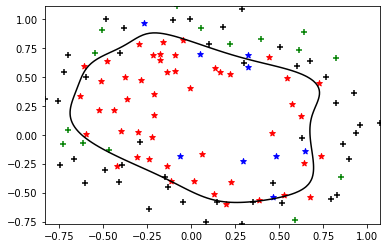

In [51]:
plot_data(X_train, y_train)
plot_data(X_test, y_test, test=True)

plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [52]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [53]:
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20,), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

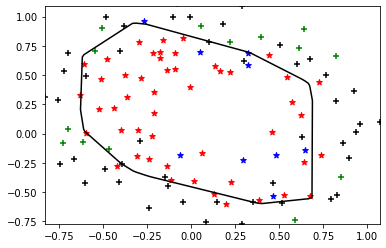

In [54]:
plot_data(X_train, y_train)
plot_data(X_test, y_test, test=True)
plot_surface(clf, X_train[:, 0], X_train[:, 1])

In [55]:
pred = clf.predict(X_test)
accuracy_score(y_test, clf.predict(X_test))

0.875